### Decision Tree con Heart Disease Dataset

1. Importar el dataset
2. Identificar y lidiar con valores faltantes
3. Dividir el dataset en X e y
4. Formatear los datos para utilizarlos en la construcción del árbol de decisión
5. Construir un árbol de decisión preliminar
6. Aplicar post-pruning y comparar cuál es el mejor resultado
7. Construir, dibujar, interpretar y evaluar el último árbol de decisión obtenido

In [182]:
# !pip install ucimlrepo

In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


### 1. Importar el dataset

In [2]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45)
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
  
df = pd.concat([X, y], axis=1)

df = df.rename(columns={'num':'hd'})
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


- age
- sex
- cp, chest pain
- trestbps
- restbp, resting blood pressure (in mm Hg)
- chol, serum cholesterol in mg/dl
- fbs, fasting blood sugar
- restecg, resting electrocardiographic results
- thalach, maximum heart rate achieved
- exang, exercise induced angina
- oldpeak, ST depression induced by exercise relative to rest
- slope, the slope of the peak exercise ST segment
- ca, number of major vessels (0–3) colored by fluoroscopy
- thal, this is short of thallium heart scan
- hd, heart disease, variable objetivo, tiene o no la enfermedad de corazon

### 2. Identificar y lidiar con Missing Data

- ¿Qué variables tienen valores faltantes?
- Comprueba los valores únicos de las variables que tienen valores faltantes
- Borra las filas que tienen valores faltantes

In [3]:
# ---------------------------------------------------------
# 1. ¿QUÉ VARIABLES TIENEN VALORES FALTANTES?
# ---------------------------------------------------------
# Sumamos los valores nulos (NaN) por cada columna
print("--- Conteo de valores nulos por columna ---")
valores_faltantes = df.isnull().sum()
# Mostramos solo las que tienen algo mayor a 0
print(valores_faltantes[valores_faltantes > 0])

# ---------------------------------------------------------
# 2. COMPROBAR VALORES ÚNICOS (de las columnas sospechosas)
# ---------------------------------------------------------
# Normalmente en este dataset son 'ca' y 'thal'. Vamos a inspeccionarlas.
print("\n--- Valores únicos en 'ca' (antes de limpiar) ---")
print(df['ca'].unique())

print("\n--- Valores únicos en 'thal' (antes de limpiar) ---")
print(df['thal'].unique())

# ---------------------------------------------------------
# 3. BORRAR LAS FILAS CON VALORES FALTANTES
# ---------------------------------------------------------
# Guardamos cuántas filas teníamos antes
filas_antes = len(df)

# Eliminamos cualquier fila que tenga al menos un NaN
df_clean = df.dropna()

# Verificamos
filas_despues = len(df_clean)
print(f"\n--- Resultado de la limpieza ---")
print(f"Filas originales: {filas_antes}")
print(f"Filas eliminadas: {filas_antes - filas_despues}")
print(f"Filas restantes: {filas_despues}")

# Comprobación final: ¿Queda algún nulo?
print("¿Quedan nulos?:", df_clean.isnull().sum().sum())

--- Conteo de valores nulos por columna ---
ca      4
thal    2
dtype: int64

--- Valores únicos en 'ca' (antes de limpiar) ---
[ 0.  3.  2.  1. nan]

--- Valores únicos en 'thal' (antes de limpiar) ---
[ 6.  3.  7. nan]

--- Resultado de la limpieza ---
Filas originales: 303
Filas eliminadas: 6
Filas restantes: 297
¿Quedan nulos?: 0


### 3. Dividir el dataset en X e y

In [6]:
X = df_clean.drop('hd', axis=1)

y = df_clean['hd']

print(f"Tamaño de X (Features): {X.shape}")
print(f"Tamaño de y (Target): {y.shape}")

Tamaño de X (Features): (297, 13)
Tamaño de y (Target): (297,)


### 4. Formatear los datos para utilizarlos en la construcción del árbol de decisión

- Identifica las variables categóricas y las distintas categorías que tiene cada una
- Para las variables categóricas de 3 o más categorías, formatéalas con one-hot encoding
- Las variables categóricas binarias déjalas como están

In [7]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])

print(X_encoded.head())
print(X_encoded.columns)

   age  sex  trestbps  chol  fbs  thalach  exang  oldpeak   ca   cp_1  ...  \
0   63    1       145   233    1      150      0      2.3  0.0   True  ...   
1   67    1       160   286    0      108      1      1.5  3.0  False  ...   
2   67    1       120   229    0      129      1      2.6  2.0  False  ...   
3   37    1       130   250    0      187      0      3.5  0.0  False  ...   
4   41    0       130   204    0      172      0      1.4  0.0  False  ...   

    cp_4  restecg_0  restecg_1  restecg_2  slope_1  slope_2  slope_3  \
0  False      False      False       True    False    False     True   
1   True      False      False       True    False     True    False   
2   True      False      False       True    False     True    False   
3  False       True      False      False    False    False     True   
4  False      False      False       True     True    False    False   

   thal_3.0  thal_6.0  thal_7.0  
0     False      True     False  
1      True     False     Fals

### 5. Construir un árbol de decisión preliminar

- Divide el dataset en training y testing
- Entrena los datos con el árbol de decisión (DecisionTreeClassifier) sin parámetros
- Construye el árbol de decisión
- Muestra la matriz de confusión frente a las predicciones de los datos de test

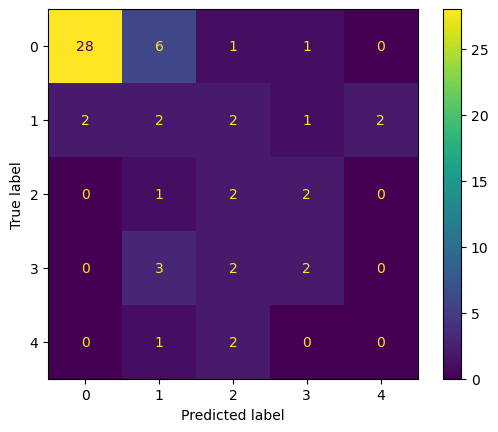

In [13]:
#### 5. Construir un árbol de decisión preliminar

#- Divide el dataset en training y testing
#- Entrena los datos con el árbol de decisión (DecisionTreeClassifier) sin parámetros
#- Construye el árbol de decisión
#- Muestra la matriz de confusión frente a las predicciones de los datos de test
#haz un arbol
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


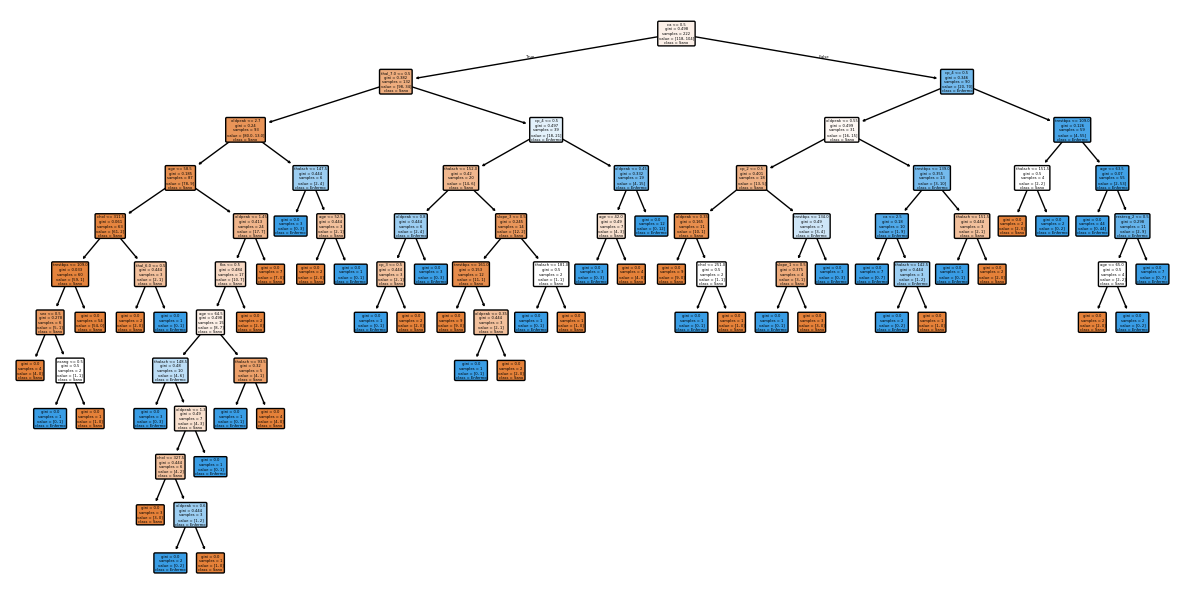

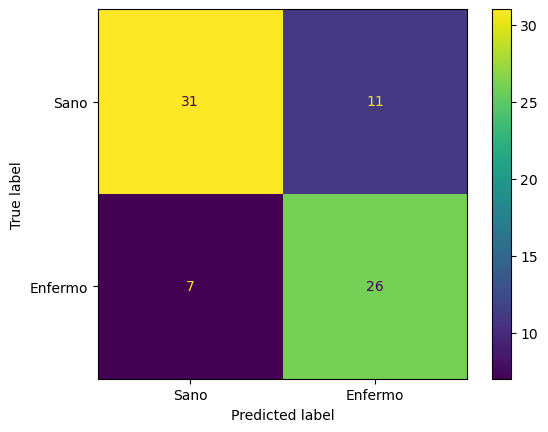

In [2]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

heart_disease = fetch_ucirepo(id=45) 
X_raw = heart_disease.data.features 
y_raw = heart_disease.data.targets 

df = pd.concat([X_raw, y_raw], axis=1)
df = df.rename(columns={'num':'hd'})
df_clean = df.dropna()

X = df_clean.drop('hd', axis=1)
y = df_clean['hd']

y = y.apply(lambda x: 1 if x > 0 else 0)

X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["Sano", "Enfermo"], 
          feature_names=X_encoded.columns)
plt.show()

predictions = clf_dt.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sano", "Enfermo"])
disp.plot()
plt.show()

### 6. Aplicar post-pruning y comparar cuál es el mejor resultado

- Obtener los valores posibles de alpha para el pruning
- Entrenar un árbol por cada valor de alpha
- Comparar la precisión en entrenamiento y test
- Usar validación cruzada (5-fold) para encontrar el mejor ccp_alpha
- Seleccionar el valor óptimo de alpha y guardarlo como un número (float)

Para ello, COMPLETA el código:

In [3]:
# 1. Obtener los valores de alpha para el pruning
# Usamos el árbol gigante (clf_dt) y los datos de entrenamiento
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1] # Quitamos el último porque es un árbol de solo la raíz (inútil)

# 2. Entrenar un árbol por cada valor de alpha
clf_dts = []
for ccp_alpha in ccp_alphas:
    clf_dt_temp = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt_temp.fit(X_train, y_train)
    clf_dts.append(clf_dt_temp)

print(f"Se entrenaron {len(clf_dts)} árboles candidatos.")

Se entrenaron 26 árboles candidatos.


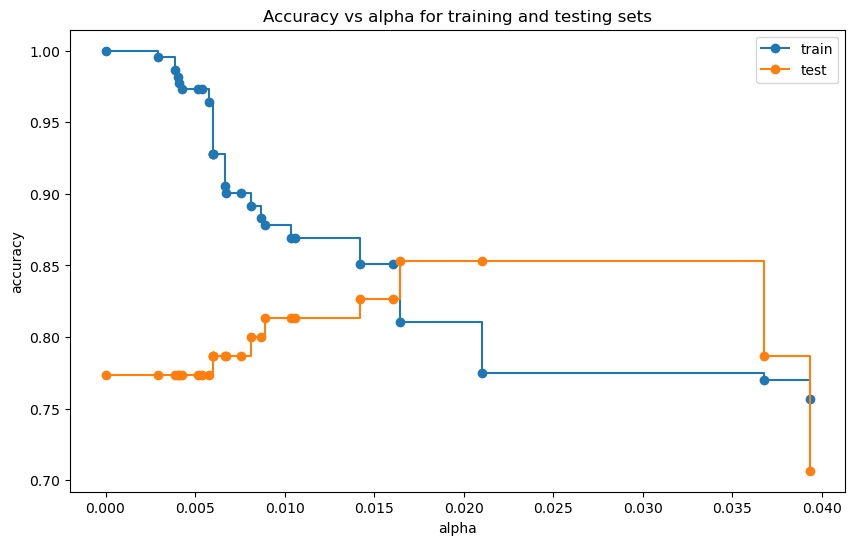

In [4]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

¿Qué representa esta gráfica?

In [ ]:
# 1. Crear el árbol con el MEJOR alpha que encontramos antes
# Usamos la variable 'best_alpha' que calculamos en el paso anterior
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)

# 2. Hacer la validación cruzada (5 exámenes)
# Argumentos: (El Modelo, Las Preguntas, Las Respuestas, Número de exámenes)
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)

# 3. Guardar resultados para graficar
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

# 4. Pintar la gráfica de estabilidad
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
plt.title("Estabilidad del Modelo (Accuracy por Fold)")
plt.ylabel("Accuracy")
plt.xlabel("Número de Fold (Iteración)")
plt.show()

print(f"Precisión promedio final: {scores.mean():.2f}")
print(f"Desviación estándar (Riesgo): {scores.std():.2f}")

El gráfico anterior muestra que el uso de diferentes datos de entrenamiento y prueba con el mismo valor de alpha dio como resultado distintas precisiones, lo que sugiere que alpha es sensible a los conjuntos de datos. Por lo tanto, en lugar de elegir un único conjunto de datos de entrenamiento y uno de prueba, usemos validación cruzada para encontrar el valor óptimo de ccp_alpha

Recuerda que validación cruzada divide los datos en x partes y entrena y evalúa el modelo x veces, usando cada parte una vez como conjunto de test

In [ ]:
### buscar el mejor alpha usando validación cruzada
alpha_loop_values = []

## para cada valor candidato de alpha, ejecutaremos validación cruzada 
## para encontrar el mejor alpha
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=____)
    scores = cross_val_score(____, ____, ____, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])


alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')


La gráfica muestra cómo cambia el rendimiento del modelo según alpha.
El mejor alpha suele ser donde la precisión media es alta y la variabilidad baja

In [ ]:
### en base a la gráfica entre que valores se encuentra el mejor alpha?
### en base a la pregunta anterior, obtén el mejor alpha
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > ____) &
                                (alpha_results['alpha'] < ____)]['alpha']

ideal_ccp_alpha


In [ ]:
## convierte el alpha ideal en float
ideal_ccp_alpha = float(ideal_ccp_alpha)
ideal_ccp_alpha

### 7. Construir, dibujar, interpretar y evaluar el último árbol de decisión obtenido

- Construye el árbol de decisión final con el mejor alpha como parámetro
- Muestra la matriz de confusión
- Dibuja el árbol de decisión final e interprétalo

¿Ha mejorado el rendimiento del modelo?